# Tutorial 10 – Model Selection

### This notebook contains all the sample code and solutions to the model assessment for model selection.
#### You will learn:

1. The use of validation dataset
2. Linear regression models with regularizations.
3. Post pruning decision tree with complexity penalty
4. Cross-validation

# 1. Linear regression using the Normal Equation

## 1.1 First, let's generate a dataset for linear regression: $y=3*x+4+\epsilon$

In [103]:
import numpy.random as rnd # this is a library for random number generation
rnd.seed(1)
X = 2 * rnd.rand(100, 1)
y = 4 + 3 * X + rnd.randn(100, 1)

## 1.2 Let's take a look at the data distribution

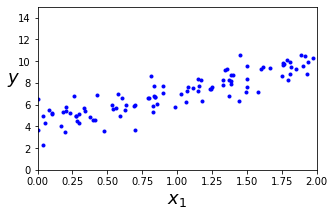

In [104]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (5,3)
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0, 2, 0, 15])
plt.savefig("generated_data_plot.png")
plt.show()

## 1.3 Then, we can find a linear regression model from the library and fit the data. The fit result shows a regression line of 

In [105]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression() # define your model
lin_reg.fit(X, y)  # fit your model using the data

#this step shows the intercept and coefficients of your fit result
print('Slope is %f, Intercept is %f'%(lin_reg.coef_, lin_reg.intercept_))
print('Linear Function is y=%f * x + %f'%(lin_reg.coef_, lin_reg.intercept_))

Slope is 2.842463, Intercept is 4.236957
Linear Function is y=2.842463 * x + 4.236957


## 1.4 After the model is trained, we can use it to predict the Y values of new data points given X values

We can see the regression line predict the Y-values as the black dot. The real Y values are represented as yellow stars.

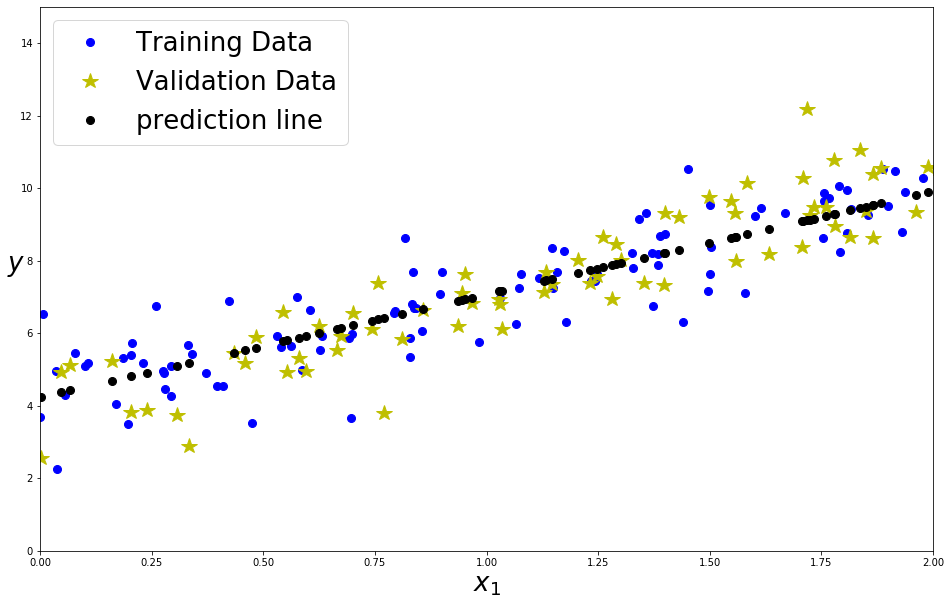

In [106]:
X_new=3 * rnd.rand(100, 1) # here we generate a set of new data points of X
Y_new = 4 + 3 * X_new + rnd.randn(100, 1) # here we generate a set of new data points of Y
plt.figure(figsize=(16,10))
Y_new_predict=lin_reg.predict(X_new) # we use the regression model to predict the Y value of the new data points
plt.plot(X, y, "b.",markersize=16)
plt.plot(X_new,Y_new,"*",color='y',markersize=16)
plt.plot(X_new,Y_new_predict,".",color='black',markersize=16)
plt.xlabel("$x_1$", fontsize=26)
plt.ylabel("$y$", rotation=0, fontsize=26)
plt.axis([0, 2, 0, 15])
plt.legend(['Training Data','Validation Data','prediction line'],fontsize=26)

plt.show()

## 1.5 Evaluate the performance of regression line using new data points.
Here we can use some evaluation metric to evaluate the performance of your data.
We try R-square to evaluate.
Check https://scikit-learn.org/stable/modules/model_evaluation.html#the-scoring-parameter-defining-model-evaluation-rules for more evaluation metrics

In [107]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
evaluation_result=mean_absolute_error(Y_new, Y_new_predict)
print('MAE=%f' %evaluation_result)

MAE=0.750172


# 2. Deal with model complexity - Ridge Regression

reference: https://www.analyticsvidhya.com/blog/2016/01/ridge-lasso-regression-python-complete-tutorial/

### 2.1 Lets fist generate a dataset from y=Sin(x)+noise for fitting 

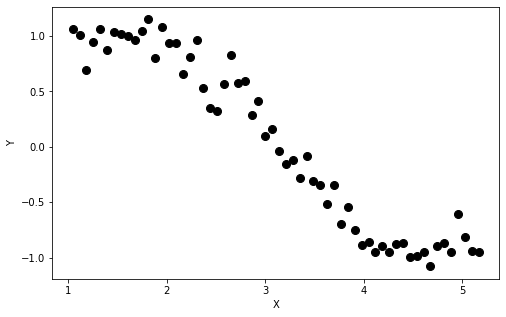

          x         y       x^2       x^3       x^4       x^5       x^6  \
0  1.047198  1.065763  1.096623  1.148381  1.202581  1.259340  1.318778   
1  1.117011  1.006086  1.247713  1.393709  1.556788  1.738948  1.942424   
2  1.186824  0.695374  1.408551  1.671702  1.984016  2.354677  2.794587   
3  1.256637  0.949799  1.579137  1.984402  2.493673  3.133642  3.937850   
4  1.326450  1.063496  1.759470  2.333850  3.095735  4.106339  5.446854   

        x^7       x^8        x^9       x^10       x^11       x^12       x^13  \
0  1.381021  1.446202   1.514459   1.585938   1.660790   1.739176   1.821260   
1  2.169709  2.423588   2.707173   3.023942   3.377775   3.773011   4.214494   
2  3.316683  3.936319   4.671717   5.544505   6.580351   7.809718   9.268760   
3  4.948448  6.218404   7.814277   9.819710  12.339811  15.506664  19.486248   
4  7.224981  9.583578  12.712139  16.862020  22.366630  29.668222  39.353420   

        x^14       x^15  
0   1.907219   1.997235  
1   4.707635   5

In [108]:
#Importing libraries. The same will be used throughout the article.
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
plt.figure(figsize=(8,5))
#Define input array with angles from 60deg to 300deg converted to radians
x = np.array([i*np.pi/180 for i in range(60,300,4)])
np.random.seed(10)  #Setting seed for reproducibility
y = np.sin(x) + np.random.normal(0,0.15,len(x))
data = pd.DataFrame(np.column_stack([x,y]),columns=['x','y'])
plt.plot(data['x'],data['y'],".",color='black',markersize=16)
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

#create new variables for x^k
for i in range(2,16):  #power of 1 is already there
    colname = 'x^%d'%i      #new var will be x_power
    data[colname] = data['x']**i
print(data.head())

## 2.2 We can use a complex models to fit, which may have overfitting issue:

for example, we can use **polynomial regression**:

$$y=a0+a1*x + a2*x^2+a3*x^3+...a15*x^{15}$$


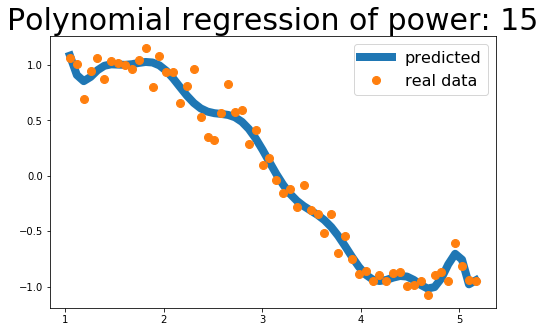

In [110]:
from sklearn.linear_model import LinearRegression
plt.figure(figsize=(8,5))

power=15
predictors=['x']
predictors.extend(['x^%d'%i for i in range(2,power+1)])#we extend the orignial feature x to the power of 2, 3, ..., 15

linreg = LinearRegression(normalize=True) #set up the model. 
# If this parameter "normalize" is set to True, 
#the regressor X will be normalized before regression. 
#The normalization will be done by subtracting the mean and dividing it by L2 norm.
linreg.fit(data[predictors],data['y'])
y_pred = linreg.predict(data[predictors])

plt.plot(data['x'],y_pred,linewidth=8)
plt.plot(data['x'],data['y'],'.',markersize=16)
plt.title('Polynomial regression of power: %d'%power,fontsize=30)
plt.legend(['predicted','real data'],fontsize=16)
plt.show()


### Let's take a look at the training error and coefficients from this fitting.

The training error is small. But the coefficients are very large.

In [112]:
print('Training Error= %f' %mean_absolute_error(data['y'], y_pred))
print('intercept=%f' %linreg.intercept_)
for i in range(len(linreg.coef_)):
    print('a%d=%f' %(i+1,linreg.coef_[i]))

Training Error= 0.083247
intercept=-36245.754240
a1=243849.458248
a2=-745846.891432
a3=1376182.115852
a4=-1713671.295664
a5=1526174.708108
a6=-1004785.035047
a7=498297.392650
a8=-187815.784471
a9=53846.150712
a10=-11656.510430
a11=1872.788334
a12=-216.361483
a13=16.983535
a14=-0.810661
a15=0.017753


## 2.3 Ridge regression set penalty to coefficient size:

## Regression penalty: α * (sum of square of coefficients)

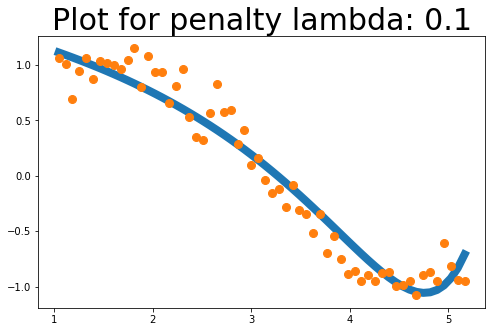

In [116]:
from sklearn.linear_model import Ridge
plt.figure(figsize=(8,5))

alpha=0.1 #the penlty term is set to be 0.1
#Fit the model
ridgereg = Ridge(alpha=alpha,normalize=True)
ridgereg.fit(data[predictors],data['y'])
y_pred = ridgereg.predict(data[predictors])

    
#Check if a plot is to be made for the entered alpha
plt.plot(data['x'],y_pred,linewidth=8)
plt.plot(data['x'],data['y'],'.',markersize=16)
plt.title('Plot for penalty lambda: %.3g'%alpha,fontsize=30)
plt.show()

### Let's take a look at the training error and coefficients from this fitting.

The training error is larger. But the coefficients are significantly reduced. The model is reduced to a simpler form.

In [118]:
print('Training Error= %f' %mean_absolute_error(data['y'], y_pred))
print('intercept=%f' %ridgereg.intercept_)
for i in range(len(ridgereg.coef_)):
    print('a%d=%f' %(i+1,ridgereg.coef_[i]))

Training Error= 0.146744
intercept=1.392827
a1=-0.224699
a2=-0.033668
a3=-0.005179
a4=-0.000733
a5=-0.000091
a6=-0.000009
a7=-0.000000
a8=0.000000
a9=0.000000
a10=0.000000
a11=0.000000
a12=0.000000
a13=0.000000
a14=0.000000
a15=0.000000


## 3. Post pruning decision trees with complexity penalty for Breast Cancer Diagnostic
[Reference](https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html#sphx-glr-auto-examples-tree-plot-cost-complexity-pruning-py)

The copy of UCI ML Breast Cancer Wisconsin (Diagnostic) dataset is downloaded from: https://goo.gl/U2Uwz2

Features are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. They describe characteristics of the cell nuclei present in the image.

Separating plane described above was obtained using Multisurface Method-Tree (MSM-T) [K. P. Bennett, “Decision Tree Construction Via Linear Programming.” Proceedings of the 4th Midwest Artificial Intelligence and Cognitive Science Society, pp. 97-101, 1992], a classification method which uses linear programming to construct a decision tree. Relevant features were selected using an exhaustive search in the space of 1-4 features and 1-3 separating planes.

The actual linear program used to obtain the separating plane in the 3-dimensional space is that described in: [K. P. Bennett and O. L. Mangasarian: “Robust Linear Programming Discrimination of Two Linearly Inseparable Sets”, Optimization Methods and Software 1, 1992, 23-34].

In [124]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
from sklearn.tree import DecisionTreeClassifier

We load the attributes and class label for each digitized image of a fine needle aspirate (FNA) of a breast mass. 
The detailed measurement of a cell can be found here: [data description](https://scikit-learn.org/stable/datasets/toy_dataset.html#breast-cancer-dataset)

In [125]:
X,y = load_breast_cancer(return_X_y=True)
#randomly split the dataset. By default, the test_size=0.25
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)  
X[0]

array([1.8e+01, 1.0e+01, 1.2e+02, 1.0e+03, 1.2e-01, 2.8e-01, 3.0e-01,
       1.5e-01, 2.4e-01, 7.9e-02, 1.1e+00, 9.1e-01, 8.6e+00, 1.5e+02,
       6.4e-03, 4.9e-02, 5.4e-02, 1.6e-02, 3.0e-02, 6.2e-03, 2.5e+01,
       1.7e+01, 1.8e+02, 2.0e+03, 1.6e-01, 6.7e-01, 7.1e-01, 2.7e-01,
       4.6e-01, 1.2e-01])

In [126]:
y[0:20] # binary targets

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

### 3.1. Use cost_complexity_pruning_path to generage pentalties alpha

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

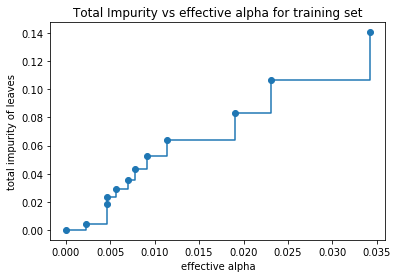

In [127]:
clf = DecisionTreeClassifier(random_state=0)
path = clf.cost_complexity_pruning_path(X_train, y_train) #seeking alpha
ccp_alphas, impurities = path.ccp_alphas, path.impurities #output apha and tree impurities

fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

### 3.2. Use different penalty alpha to generate different tree structure.

In [128]:
clfs = [] #this list will be used to store a list of Decision Tree Models with different penalty alpha values.
for alpha in ccp_alphas:
    print('the penalty term alpha is %f' %alpha)
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=alpha) # induce a tree using the ccp_alpha value
    clf.fit(X_train, y_train)
    clfs.append(clf)

the penalty term alpha is 0.000000
the penalty term alpha is 0.002266
the penalty term alpha is 0.004647
the penalty term alpha is 0.004660
the penalty term alpha is 0.005634
the penalty term alpha is 0.007042
the penalty term alpha is 0.007842
the penalty term alpha is 0.009114
the penalty term alpha is 0.011444
the penalty term alpha is 0.018988
the penalty term alpha is 0.023142
the penalty term alpha is 0.034225
the penalty term alpha is 0.327298


### 3.2.1 The first tree using the first panelty alpha (ccp_alphas[0])

the first alphas is:  0.0


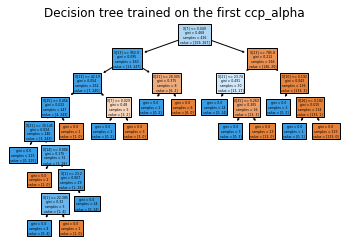

In [129]:
from sklearn.tree import plot_tree
print('the first alphas is: ', ccp_alphas[0]) #the first alpha value in the list of ccp_alphas generated.
plot_tree(clfs[0], filled=True)
plt.title("Decision tree trained on the first ccp_alpha")
plt.show()

the 5th alphas is:  0.007042253521126761


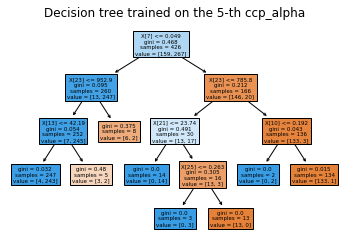

In [130]:
print('the 5th alphas is: ', ccp_alphas[5])
plot_tree(clfs[5], filled=True)
plt.title("Decision tree trained on the 5-th ccp_alpha")
plt.show()

the last alphas is:  0.3272984419327777


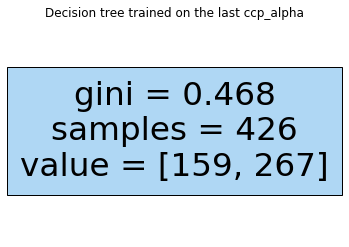

In [131]:
print('the last alphas is: ', ccp_alphas[-1])
plot_tree(clfs[-1], filled=True)
plt.title("Decision tree trained on the last ccp_alpha")
plt.show()

## 3.3 Show the model complexity VS penalty alpha

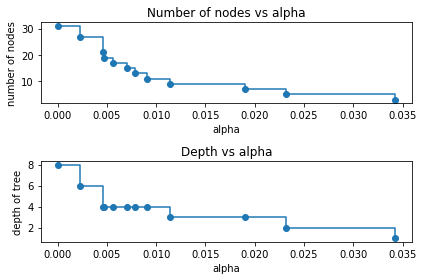

In [132]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

## 4. General Model Selection using Cross-validation Score

Details of CV, please check documentation: 
https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-iterators 

### We use straitified Cross Validation to evaluate a 3-class classificaion problem using the iris dataset
<img src ="https://scikit-learn.org/stable/_images/sphx_glr_plot_cv_indices_003.png" width="600">

In [133]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis


In [135]:
data = pd.read_csv('iris.txt',header=None)  #use tool "read_csv" to read the data in "iris.txt" file. the data is stored in "data"
data.columns = ['sepal length', 'sepal width', 'petal length', 'petal width', 'class'] #set the column names of the data table 
data.head(10) # 

,sepal length,sepal width,petal length,petal width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
5,5.4,3.9,1.7,0.4,Iris-setosa
6,4.6,3.4,1.4,0.3,Iris-setosa
7,5.0,3.4,1.5,0.2,Iris-setosa
8,4.4,2.9,1.4,0.2,Iris-setosa
9,4.9,3.1,1.5,0.1,Iris-setosa


In [136]:
Y = data['class'] #this is our prediction target
X = data.drop(['class'],axis=1)

In [138]:
from sklearn.model_selection import cross_val_score
clf=KNeighborsClassifier(10)
scores = cross_val_score(clf, X, Y, cv=5)
print('KNN CV Score:', scores)

KNN CV Score: [1.  1.  1.  0.9 1. ]


In [139]:
clf=DecisionTreeClassifier(max_depth=10)
scores = cross_val_score(clf, X, Y, cv=5)
print('DT CV Score:', scores)

DT CV Score: [1.  1.  0.9 1.  1. ]


### Use all possible classification models for model comparison:

In [143]:
h = 0.02  # step size in the mesh

names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
    "QDA",
]

classifiers = [
    KNeighborsClassifier(10),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
]

In [144]:
for i in range(len(classifiers)):
    clf=classifiers[i] #use the i-th model in the "classifiers" list
    scores = cross_val_score(clf, X, Y, cv=5)
    print('CV Score of '+ names[i], scores)

CV Score of Nearest Neighbors [1.  1.  1.  0.9 1. ]
CV Score of Linear SVM [0.9 1.  0.9 0.9 1. ]
CV Score of RBF SVM [1.  1.  0.9 1.  1. ]


/Users/junming/opt/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/_gpc.py:451: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


CV Score of Gaussian Process [1.  1.  0.9 0.9 1. ]
CV Score of Decision Tree [1.  1.  0.9 1.  1. ]
CV Score of Random Forest [1.  1.  0.9 0.9 1. ]
CV Score of Neural Net [1. 1. 1. 1. 1.]
CV Score of AdaBoost [1.  0.9 0.9 0.9 1. ]
CV Score of Naive Bayes [0.9 1.  0.9 0.9 1. ]
CV Score of QDA [1.  1.  1.  0.9 1. ]


### Hold-out with classification report

                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        17
Iris-versicolor       0.95      0.95      0.95        19
 Iris-virginica       0.93      0.93      0.93        14

       accuracy                           0.96        50
      macro avg       0.96      0.96      0.96        50
   weighted avg       0.96      0.96      0.96        50

[[17  0  0]
 [ 0 18  1]
 [ 0  1 13]]


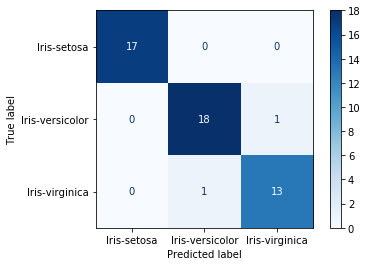

In [145]:
from sklearn.metrics import classification_report # this library directly generates precision, recall, f-measure
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix

clf=DecisionTreeClassifier(max_depth=10)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=1)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)

print(classification_report(y_test, y_pred))

disp = plot_confusion_matrix(clf, X_test, y_test,values_format = '.0f',cmap=plt.cm.Blues)
np.set_printoptions(precision=1)
print(disp.confusion_matrix)

For multi-class classification problem, micro-average precision scores can be defined as sum of true positives for all the classes divided by the all positive predictions. The positive prediction is sum of all true positives and false positives. Here is how it would look like mathematically:

$𝑃𝑟𝑒𝑐𝑖𝑠𝑖𝑜𝑛𝑀𝑖𝑐𝑟𝑜𝐴𝑣𝑔=\frac{(𝑇𝑃_1+𝑇𝑃_2+𝑇𝑃_3)}{(𝑇𝑃_1+𝑇𝑃_2+𝑇𝑃_3+𝐹𝑃_1+𝐹𝑃_2+𝐹𝑃_3)}$

Macro-average precision score can be defined as the arithmetic mean of all the precision scores of different classes. Here is how it would look like mathematically:

$𝑃𝑟𝑒𝑐𝑖𝑠𝑖𝑜𝑛𝑀𝑎𝑐𝑟𝑜𝐴𝑣𝑔=\frac{(𝑃𝑟𝑒𝑐_1+𝑃𝑟𝑒𝑐_2+𝑃𝑟𝑒𝑐_3)}{3}$

# Summary
## 1. Learn how to get linear regression models: 
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

## 2. Learn how to use different evaluation metrics for prediction
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

## 3. Learn how to change the regularization penalties (the alpha)
ridge_reg = Ridge(alpha=1, solver="cholesky")

## 4. Learn how to conduct model selection

------------------------------------------------------------------------------------------

## Assignment Week 10 - Due Week 11

### 1. Use the Breast Cancer Wisconsin (Diagnostic) dataset to select the best decision tree structure that has the minimum testing error.

### 2. Does the Breast Cancer Wisconsin (Diagnostic) dataset has imbalanced issue? If so, select the best model according to your own evaluation metric and report the result

### 3. Use 5-fold cross-validation to select the best tree structure for the Breast Cancer Wisconsin (Diagnostic) dataset.

### 4. Use the same dataset, compare the performance of the best tree structure and the Random Forest method. Which model do you prefer?